### Saturated Growth Model
$$ u' = u(C-u) $$
$$u(t=0) = u_0 = 0.01$$
and
$$C_{true} = 1$$

Exact solution:
$$u(t) = \frac{C}{1 + (\frac{C - u_0}{u_0}) e^{-Ct}} $$

##### Workflow Overview

1. Define the **problem domain**, by using the `fbpinns.domains.RectangularDomainND` class
2. Define the **ODE** to solve, and its **problem constraints**, by defining our own `fbpinns.problems.Problem` class
3. Define the **domain decomposition** used by the FBPINN, by using the `fbpinns.decompositions.RectangularDecompositionND` class
4. Define the **neural network** placed in each subdomain, by using the `fbpinns.networks.FCN` class
5. Pass these classes and their initialisation values to a `fbpinns.constants.Constants` object
6. Start the FBPINN training by instantiating a `fbpinns.trainer.FBPINNTrainer` using the `Constants` object.

##### Step 1: Problem Domain

In [3]:
import sys
import os

module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path)


In [4]:
import sys
import os

module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path)
import numpy as np
from fbpinns.domains import RectangularDomainND

domain = RectangularDomainND
domain_init_kwargs = dict(
    xmin = np.array([0.,]),
    xmax = np.array([24.,])
)

domain_init_kwargs

{'xmin': array([0.]), 'xmax': array([24.])}

##### Step 2: Define the ODE to solve

In [5]:
import jax.numpy as jnp
from fbpinns.problems import Problem

In [36]:
class SaturatedGrowthModel(Problem):
    """
    u' = u(C-u)
    I.C.
    u(0) = u_0 = 0.01
    """

    @staticmethod
    def init_params(C=1, u0=0.01, sd=0.1):
        
        static_params = {
            "dims":(1,1),
            "C_ture":C,
            "u_0":u0,
            "sd":sd,
        }
        trainable_params = {
            "C":jnp.array(0.), # learn C from constraints
        }

        return static_params, trainable_params
    
    @staticmethod 
    def exact_solution(all_params, x_batch, batch_shape=None):
        u0 = all_params["static"]["problem"]["u_0"]
        C = all_params["static"]["problem"]["C_ture"]

        exp = jnp.exp(-C*x_batch)
        u = C / (1 + ((C - u0) / u0) * exp)
        return u
    
    
    @staticmethod
    def sample_constraints(all_params, domain, key, sampler, batch_shapes):

        # Physics Loss
        x_batch_phys = domain.sample_interior(all_params, key, sampler, batch_shapes[0])
        required_ujs_phys = (
            (0, ()),
            (0, (0,)),
        )

        # Data Loss
        x_batch_data = jnp.linspace(10,24,15).astype(float).reshape((15,1)) #15 data observation
        u_data = SaturatedGrowthModel.exact_solution(all_params, x_batch_data)
        required_ujs_data = (
            (0, ()),
        )
        return [[x_batch_phys, required_ujs_phys],
                [x_batch_data, u_data, required_ujs_data]]
    
    @staticmethod
    def constraining_fn(all_params, x_batch, u):
        sd = all_params["static"]["problem"]["sd"]
        u0 = all_params["static"]["problem"]["u_0"]

        x, tanh = x_batch[:,0:1], jnp.tanh

        u = u0 + tanh(x/sd) * u
        
        return u
    
    @staticmethod
    def loss_fn(all_params, constraints):

        C = all_params["trainable"]["problem"]["C"]
        # physics loss
        _, u, ut = constraints[0]
        phys = jnp.mean((ut - u*(C-u))**2)

        # data loss
        _, uc, u = constraints[1]
        data = 1e6*jnp.mean((u-uc)**2)

        return phys + data

problem = SaturatedGrowthModel
problem_init_kwargs = dict(
    C=1, u0=0.01, # define the ode parameters, sd[optional; default=0.1]
)
        

step 3: Define the domain decomposition used by the FBPINN

In [37]:
from fbpinns.decompositions import RectangularDecompositionND

decomposition = RectangularDecompositionND # use a rectangular domain decomposition

decomposition_init_kwargs = dict(
    subdomain_xs = [np.linspace(0,24,15)],
    subdomain_ws = [(24/12)*np.ones((15,))],
    unnorm = (0., 1.),
)
subdomain_xs = [np.linspace(0,24,15)]
subdomain_ws = [(24/12)*np.ones((15,))]
print(subdomain_xs)
print(subdomain_ws)

[array([ 0.        ,  1.71428571,  3.42857143,  5.14285714,  6.85714286,
        8.57142857, 10.28571429, 12.        , 13.71428571, 15.42857143,
       17.14285714, 18.85714286, 20.57142857, 22.28571429, 24.        ])]
[array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.])]


step 4: Define the neural network placed in each subdomain

In [38]:
from fbpinns.networks import FCN

network = FCN# place a fully-connected network in each subdomain
network_init_kwargs=dict(
    layer_sizes=[1,32,1],# with 2 hidden layers
)

step 5: Create a constants object

In [39]:
from fbpinns.constants import Constants

c = Constants(
    domain=domain,
    domain_init_kwargs=domain_init_kwargs,
    problem=problem,
    problem_init_kwargs=problem_init_kwargs,
    decomposition=decomposition,
    decomposition_init_kwargs=decomposition_init_kwargs,
    network=network,
    network_init_kwargs=network_init_kwargs,
    ns=((2000,),),# use 200 collocation points for training
    n_test=(500,),# use 500 points for testing
    n_steps=50000,# number of training steps
    clear_output=True,
)

print(c)

run: test
domain: <class 'fbpinns.domains.RectangularDomainND'>
domain_init_kwargs: {'xmin': array([0.]), 'xmax': array([24.])}
problem: <class '__main__.SaturatedGrowthModel'>
problem_init_kwargs: {'C': 1, 'u0': 0.01}
decomposition: <class 'fbpinns.decompositions.RectangularDecompositionND'>
decomposition_init_kwargs: {'subdomain_xs': [array([ 0.        ,  1.71428571,  3.42857143,  5.14285714,  6.85714286,
        8.57142857, 10.28571429, 12.        , 13.71428571, 15.42857143,
       17.14285714, 18.85714286, 20.57142857, 22.28571429, 24.        ])], 'subdomain_ws': [array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.])], 'unnorm': (0.0, 1.0)}
network: <class 'fbpinns.networks.FCN'>
network_init_kwargs: {'layer_sizes': [1, 32, 1]}
n_steps: 50000
scheduler: <class 'fbpinns.schedulers.AllActiveSchedulerND'>
scheduler_kwargs: {}
ns: ((2000,),)
n_test: (500,)
sampler: grid
optimiser: <function adam at 0x0000023F0CA7FB00>
optimiser_kwargs: {'learning_rate': 0.001}
seed: 0
sum

step 6: Train the FBPINNs using a FBPINNTrainer

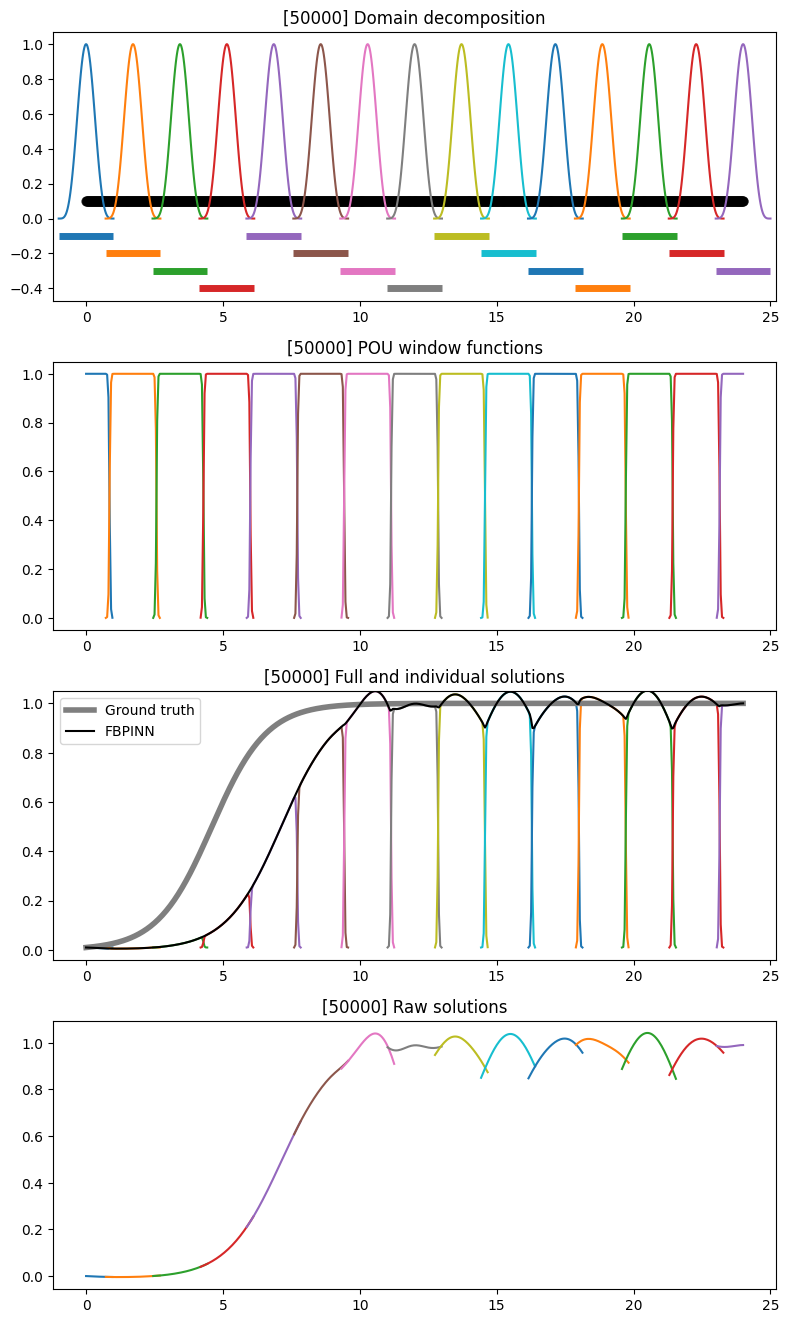

[INFO] 2024-02-17 02:18:50 - [i: 50000/50000] Training complete


In [40]:
from fbpinns.trainers import FBPINNTrainer

run = FBPINNTrainer(c)
all_params = run.train()

In [41]:
all_params["trainable"]["problem"]["C"] 

Array(1.0047019, dtype=float32)

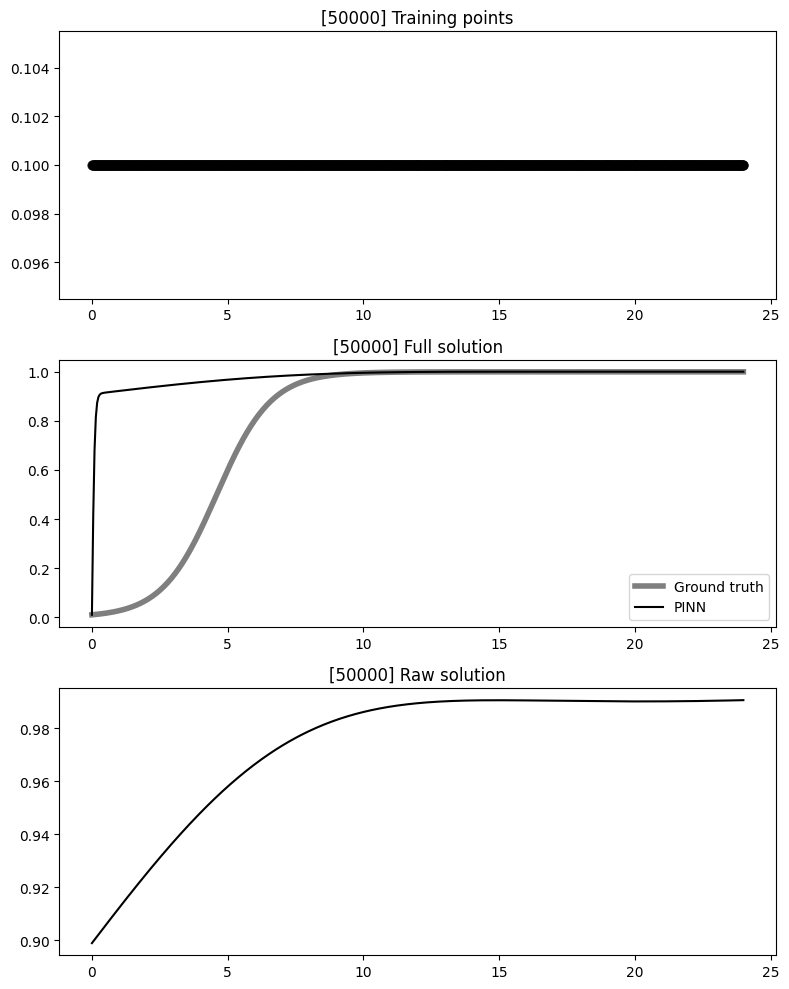

[INFO] 2024-02-17 02:21:42 - [i: 50000/50000] Training complete


In [44]:
from fbpinns.trainers import PINNTrainer

c["network_init_kwargs"] = dict(layer_sizes=[1,5,5,5,1])# use a larger neural network
run = PINNTrainer(c)
pinn_out = run.train()# start training a PINN on the same problem

In [45]:
print(all_params["trainable"]["problem"]["C"]) # previously Array(0.972242, dtype=float32)
print(pinn_out["trainable"]["problem"]["C"])

1.0047019
1.0064862
